# Estimating samples per SMRT-cell

Library > sample > reaction 

Individual IVT reactions will compose samples. In general reactions that belong to the same sample will include all inserts from a specific series of plasmids. Samples should include a transcribed untreated, transcribed RnaseH treated and untranscribed reactions.

In [1]:
reads_per_SMRT_cell = 4e6 * 0.60
per_reaction = reads_per_SMRT_cell / 3  # assuming transcribed, transcribed + RnaseH, and untranscribed
per_insert = per_reaction / 31
per_insert

25806.451612903227

Above would be reads per insert for 1 standard reaction assuming only get 60% of the SequelII advertised 4 million reads per SMRTcell. I think 1000-2000 reads per insert would be enough to do stats on so with that in mind.

In [2]:
per_insert / 2500

10.32258064516129

So could likely pull off around 10 *samples* (or 30 reactions) per SMRT cell. As long as there was a way to individualy distinguish reactions from each other.

One possible approach to doing this could be to amplify bisulfite treated products with overhanging PCR primers. 
The overhang would contain a unique ID for that reaction plus some buffer sequence on the 5' end to protect it from anything that might happen during library prep. This way after amplification any group of reactions could be combined into the same tube and could later be distinguised by sequencing.

## Designing overhanging barcoded primers

In [3]:
from dnachisel import *
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
import pandas as pd

In [4]:
class BarcodedPrimer():
    
    buffer_seq = None
    buffer_length = 10
    overhang_length = 8
    overhang_seqs = []
    
    def __init__(self, name, target, description=''):
        self.name = name
        self.target = target
        self.overhang_seq = None
        self.description = description
    
    @classmethod
    def optimize_buffer(cls):
         cls.buffer_seq = cls._optimize_seq(cls.buffer_length)
        
    @classmethod
    def _optimize_seq(cls, length):
        def resolve_sequence():
            problem = DnaOptimizationProblem(
                sequence=random_dna_sequence(length),
                constraints=[
                    AvoidPattern("EcoRI_site"),
                    AvoidPattern("SacI_site"),
                    AvoidPattern("KpnI_site"),
                    AvoidPattern("HindIII_site"),
                    AvoidPattern('6xA'),  # A homopolymers
                    AvoidPattern('3x2mer'),  # Avoid direct repeats
                    EnforceGCContent(mini=0.4, maxi=0.6, window=length)

                ]           
            )
            problem.resolve_constraints()
            problem.optimize()
            return problem.sequence
        
        def hamming_dist(seq_a, seq_b):
            
            print(seq_a, seq_b)
            assert len(seq_a) == len(seq_b)
            return sum([1 for i in range(len(seq_a)) if seq_a[i] != seq_b[i]])
        
        # Generate sequences that fit required parameters. Reattempt
        # if the hamming distance between the generated overhang
        # and any previously generated ones is > 50%. This is to
        # ensure sequences are easily IDed upon sequencing
        # only check hamming distance if length of optimize sequence
        # matches length for overhang seq set in the class variable
        seq = resolve_sequence()
        if length == cls.overhang_length:
            while True:
                for each_overhang in cls.overhang_seqs:
                    if hamming_dist(seq, each_overhang) > int(length/2):
                        break
                break
        
        return seq
    
    
    def optimize_overhang(self):
        overhang = self._optimize_seq(BarcodedPrimer.overhang_length)
        self.overhang_seq = overhang
        BarcodedPrimer.overhang_seqs.append(self.overhang_seq)
    
    
    def to_record(self):
        if self.overhang_seq == None:
            self.optimize_overhang()
        if BarcodedPrimer.buffer_seq == None:
            BarcodedPrimer.optimize_buffer()
        complete_seq = BarcodedPrimer.buffer_seq + self.overhang_seq + self.target
        
        return SeqRecord(
            Seq(complete_seq),
            id=self.name,
            name='',
            description=self.description
        )
    
    
    def to_dict(self):
        if not self.overhang_seq:
            self.to_record()
        return {
            'seq': str(self.to_record().seq),
            'buffer': BarcodedPrimer.buffer_seq,
            'barcode': self.overhang_seq,
            'target': self.target,
            'name': self.name
        }

b = BarcodedPrimer('test-1', 'ATGC')
c = BarcodedPrimer('test-2', 'ATGC')

In [5]:
print(BarcodedPrimer.overhang_seqs)

[]


In [6]:
b.to_record()

location:   0%|                                 | 0/1 [00:00<?, ?it/s, now=0-10]


SeqRecord(seq=Seq('TATTTAGCGGTGTTCCGTATGC'), id='test-1', name='', description='', dbxrefs=[])

### T7 init barcoded primers

### Forward primer target selection

First I used primer3 to pick a fwd primer in the region between ~ -150 bp and -250 bp from pFC9.
The complete sequence of this region is shown below.

```
tcgaggtgccgtaaagcactaaatcggaaccctaaagggagcccccgatttagagcttgacggggaaagccggcgaacgtggcgagaaaggaagggaagaaagcgaaaggagcgggcgctagggcgctggcaagtgtagcggtcacgctg
```

Primer3 picked out the following sequence using the web interface. Used default parameters except only picked a left primer and min length 24.

```
No mispriming library specified
Using 1-based sequence positions
OLIGO            start  len      tm     gc%   any    3' seq 
LEFT_PRIMER         15   23   60.03   43.48  3.00  2.00 agcactaaatcggaaccctaaag
SEQUENCE SIZE: 150
INCLUDED REGION SIZE: 150
```

This is the primer I will use for the target in barcoded primers. Only one primer will need a barcode and so I selected fwd primer as the barcoded primer.

### Reverse primer target selection

For the reverse primer I selected the region between 2000 and 2200 bp downstream of the pFC9VR1 construct. These region has the sequence below.

```
tccgcctccatccagtctattaattgttgccgggaagctagagtaagtagttcgccagttaatagtttgcgcaacgttgttgccattgctacaggcatcgtggtgtcacgctcgtcgtttggtatggcttcattcagctccggttcccaacgatcaaggcgagttacatgatcccccatgttgtgaaaaaaagcggttag
```

I then used the primer3 web interface to search for reverse primers in this region. Primer3 select this oligo as the best primer.

```
No mispriming library specified
Using 1-based sequence positions
OLIGO            start  len      tm     gc%   any    3' seq 
RIGHT_PRIMER        56   24   59.20   50.00  4.00  0.00 ggcgaactacttactctagcttcc
SEQUENCE SIZE: 200
INCLUDED REGION SIZE: 200
```

In all cases primer3 was used `primer3 release 1.1.4` was the version used.

### Barcoded forward primer design

In [7]:
barcoded_target = 'agcactaaatcggaaccctaaag'.upper()

Make a total of 15 barcoded primers to cover multiple potential experiments.

In [8]:
total_t7_init_primers = 30

In [9]:
t7_init_primers = []
for i in range(total_t7_init_primers):
    t7_init_primers.append(
        BarcodedPrimer(f'PacBioBarFwd-{i}', barcoded_target)
    )
    t7_init_primers[i].optimize_overhang()

location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CGGTTAGA TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CCCTCTTT TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CGTTTCTG TGTTCCGT
CGTTTCTG CGGTTAGA
CGTTTCTG CCCTCTTT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ATGGATCG TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


GGTAACAC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CAAGCAGA TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ACCTCAGT TGTTCCGT
ACCTCAGT CGGTTAGA


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TTGGCGAA TGTTCCGT


CCATGATG TGTTCCGT


CAAGTCTC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CGCGAAAT TGTTCCGT


CAAGCCAA TGTTCCGT


GCCGTATA TGTTCCGT


location:   0%|                               | 0/1 [00:00<?, ?it/s, now=2-8(+)]
                                                                                
location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]
                                                                                
location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TAGGTCTC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


GGTTGAGA TGTTCCGT
GGTTGAGA CGGTTAGA
GGTTGAGA CCCTCTTT


ATTGAGCC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TCTTTGGC TGTTCCGT
TCTTTGGC CGGTTAGA


TATGGGGA TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TACGCAAG TGTTCCGT


location:   0%|                               | 0/1 [00:00<?, ?it/s, now=1-7(+)]


CCTCTCAA TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ACAGTCGA TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CAATGCTC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TTATCCCG TGTTCCGT
TTATCCCG CGGTTAGA


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CGTCAATC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CACCTATG TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ACGGAACA TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CTTGGCTT TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ATTGCTGG TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TGGTAACC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]
                                                                                

AGACACTC TGTTCCGT


In [10]:
def barcode_primers_to_table(primer_list):
    as_dicts = [p.to_dict() for p in primer_list]
    return pd.DataFrame(as_dicts)

In [11]:
t7_init_table = barcode_primers_to_table(t7_init_primers)
t7_init_table

,seq,buffer,barcode,target,name
0,TATTTAGCGGCGGTTAGAAGCACTAAATCGGAACCCTAAAG,TATTTAGCGG,CGGTTAGA,AGCACTAAATCGGAACCCTAAAG,PacBioBarFwd-0
1,TATTTAGCGGCCCTCTTTAGCACTAAATCGGAACCCTAAAG,TATTTAGCGG,CCCTCTTT,AGCACTAAATCGGAACCCTAAAG,PacBioBarFwd-1
2,TATTTAGCGGCGTTTCTGAGCACTAAATCGGAACCCTAAAG,TATTTAGCGG,CGTTTCTG,AGCACTAAATCGGAACCCTAAAG,PacBioBarFwd-2
3,TATTTAGCGGATGGATCGAGCACTAAATCGGAACCCTAAAG,TATTTAGCGG,ATGGATCG,AGCACTAAATCGGAACCCTAAAG,PacBioBarFwd-3
4,TATTTAGCGGGGTAACACAGCACTAAATCGGAACCCTAAAG,TATTTAGCGG,GGTAACAC,AGCACTAAATCGGAACCCTAAAG,PacBioBarFwd-4
5,TATTTAGCGGCAAGCAGAAGCACTAAATCGGAACCCTAAAG,TATTTAGCGG,CAAGCAGA,AGCACTAAATCGGAACCCTAAAG,PacBioBarFwd-5
6,TATTTAGCGGACCTCAGTAGCACTAAATCGGAACCCTAAAG,TATTTAGCGG,ACCTCAGT,AGCACTAAATCGGAACCCTAAAG,PacBioBarFwd-6
7,TATTTAGCGGTTGGCGAAAGCACTAAATCGGAACCCTAAAG,TATTTAGCGG,TTGGCGAA,AGCACTAAATCGGAACCCTAAAG,PacBioBarFwd-7
8,TATTTAGCGGCCATGATGAGCACTAAATCGGAACCCTAAAG,TATTTAGCGG,CCATGATG,AGCACTAAATCGGAACCCTAAAG,PacBioBarFwd-8
9,TATTTAGCGGCAAGTCTCAGCACTAAATCGGAACCCTAAAG,TATTTAGCGG,CAAGTCTC,AGCACTAAATCGGAACCCTAAAG,PacBioBarFwd-9


In [12]:
t7_init_table.to_csv('T7InitFwdPrimers.tsv', index=None, sep='\t')

In [13]:
t7_init_records = [p.to_record() for p in t7_init_primers]

In [14]:
SeqIO.write(t7_init_records, 'T7InitBarcodedForwardPrimers.fa', 'fasta')

30

In [15]:
t7_init_rev = SeqRecord(Seq('ggcgaactacttactctagcttcc'), id='PacBioRev-0', description='')

In [16]:
SeqIO.write(
    [t7_init_rev]
    , 'T7InitBarcodedReversePrimers.fa', 'fasta')

1

## TacInit series primers

Following same design method for this series of plasmids as I did with the T7init series. Using primer3 web interface `release 1.1.4`.

### Forward primer target selection

First selected region ~150-250 bp upstream of the tac promoter, region sequence is shown below.

```
gttatccacagaatcaggggataacgcaggaaagaacatgtgagcaaaaggccagcaaaaggccaggaaccgtaaaaaggccgcgttgctggcgtttttccataggctcggcccccctgacgagcatcacaaaaatcgacgctcaagtca
```

Then used primer3 to pick a forward primer for this sequence.

```
No mispriming library specified
Using 1-based sequence positions
OLIGO            start  len      tm     gc%   any    3' seq 
LEFT_PRIMER         28   23   59.81   39.13  6.00  2.00 aggaaagaacatgtgagcaaaag
SEQUENCE SIZE: 150
INCLUDED REGION SIZE: 150
```

### Reverse primer target selection

```
tcttttactttcaccagcgtttctgggtgagcaaaaacaggaaggcaaaatgccgcaaaaaagggaataagggcgacacggaaatgttgaatactcatactcttcctttttcaatattattgaagcatttatcagggttattgtctcatg
```

Primer3 selection

```
No mispriming library specified
Using 1-based sequence positions
OLIGO            start  len      tm     gc%   any    3' seq 
RIGHT_PRIMER       148   24   59.42   37.50  2.00  2.00 tgagacaataaccctgataaatgc
SEQUENCE SIZE: 150
INCLUDED REGION SIZE: 150
```

### Barcoded forward primer design

Fewer experiments are likely to be done with this series (no Cas9 targets currently) and so fewer barcoded primers
need to be designed.

In [17]:
tac_init_barcoded = 30
tac_init_fwd_target = 'aggaaagaacatgtgagcaaaag'.upper()

In [18]:
tac_init_primers = []
for i in range(tac_init_barcoded):
    tac_init_primers.append(
        BarcodedPrimer(f'TacInitBarFwd-{i}', tac_init_fwd_target)
    )
    tac_init_primers[i].optimize_overhang()

location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CCTGATTC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TGCTAGAC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


GACGTATC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ATCGATGC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


AGTCACTC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CCTTTACG TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TCAAGTGG TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TTTTCCCC TGTTCCGT
TTTTCCCC CGGTTAGA


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CACTCAAG TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ACTCGTAC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CGCAAAGT TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


AGGACTTC TGTTCCGT


GTCTTCGA TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ATGTCACG TGTTCCGT


CGTAAAGG TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CAGATCGA TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ACATGCGA TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


GAAGTCTG TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


CAGTCTCA TGTTCCGT


AGCTGGTA TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TTGTCACC TGTTCCGT


GGGATCAT TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


AAGTCTGC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


GCGTAGTT TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ATCCTCAC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


TGACACGT TGTTCCGT
TGACACGT CGGTTAGA


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


ACCAGATC TGTTCCGT


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]


GGTCGATT TGTTCCGT


GTTTGCCT TGTTCCGT
GTTTGCCT CGGTTAGA


location:   0%|                                  | 0/1 [00:00<?, ?it/s, now=0-8]
                                                                                

ATCTCAGG TGTTCCGT


In [19]:
tac_init_table = barcode_primers_to_table(tac_init_primers)
tac_init_table

,seq,buffer,barcode,target,name
0,TATTTAGCGGCCTGATTCAGGAAAGAACATGTGAGCAAAAG,TATTTAGCGG,CCTGATTC,AGGAAAGAACATGTGAGCAAAAG,TacInitBarFwd-0
1,TATTTAGCGGTGCTAGACAGGAAAGAACATGTGAGCAAAAG,TATTTAGCGG,TGCTAGAC,AGGAAAGAACATGTGAGCAAAAG,TacInitBarFwd-1
2,TATTTAGCGGGACGTATCAGGAAAGAACATGTGAGCAAAAG,TATTTAGCGG,GACGTATC,AGGAAAGAACATGTGAGCAAAAG,TacInitBarFwd-2
3,TATTTAGCGGATCGATGCAGGAAAGAACATGTGAGCAAAAG,TATTTAGCGG,ATCGATGC,AGGAAAGAACATGTGAGCAAAAG,TacInitBarFwd-3
4,TATTTAGCGGAGTCACTCAGGAAAGAACATGTGAGCAAAAG,TATTTAGCGG,AGTCACTC,AGGAAAGAACATGTGAGCAAAAG,TacInitBarFwd-4
5,TATTTAGCGGCCTTTACGAGGAAAGAACATGTGAGCAAAAG,TATTTAGCGG,CCTTTACG,AGGAAAGAACATGTGAGCAAAAG,TacInitBarFwd-5
6,TATTTAGCGGTCAAGTGGAGGAAAGAACATGTGAGCAAAAG,TATTTAGCGG,TCAAGTGG,AGGAAAGAACATGTGAGCAAAAG,TacInitBarFwd-6
7,TATTTAGCGGTTTTCCCCAGGAAAGAACATGTGAGCAAAAG,TATTTAGCGG,TTTTCCCC,AGGAAAGAACATGTGAGCAAAAG,TacInitBarFwd-7
8,TATTTAGCGGCACTCAAGAGGAAAGAACATGTGAGCAAAAG,TATTTAGCGG,CACTCAAG,AGGAAAGAACATGTGAGCAAAAG,TacInitBarFwd-8
9,TATTTAGCGGACTCGTACAGGAAAGAACATGTGAGCAAAAG,TATTTAGCGG,ACTCGTAC,AGGAAAGAACATGTGAGCAAAAG,TacInitBarFwd-9


In [20]:
tac_init_table.to_csv('tacInitFwdPrimers.tsv', index=None, sep='\t')

Calculate hamming distance between all barcodes.

In [21]:
def ham(a, b):
    assert len(a) == len(b)
    return sum([1 for i in range(len(a)) if a[i] != b[i]]) / len(a)

In [22]:
all_barcode_primers = tac_init_primers + t7_init_primers

In [23]:
ham_dist = []
for p1 in all_barcode_primers:
    for p2 in all_barcode_primers:
        ham_dist.append(
            {
                'p1_name': p1.name,
                'p2_name': p2.name,
                'ham_dist': ham(p1.overhang_seq, p2.overhang_seq),
                'p1_id': int(p1.name.split('-')[-1]),
                'p2_id': int(p2.name.split('-')[-1]),
                'group': '1'
                
            }
        
        )

ham_dist_table = pd.DataFrame(ham_dist)
ham_dist_table = ham_dist_table.sort_values(by=['p1_id', 'p2_id'])
ham_dist_table

,p1_name,p2_name,ham_dist,p1_id,p2_id,group
0,TacInitBarFwd-0,TacInitBarFwd-0,0.000,0,0,1
30,TacInitBarFwd-0,PacBioBarFwd-0,0.875,0,0,1
1800,PacBioBarFwd-0,TacInitBarFwd-0,0.875,0,0,1
1830,PacBioBarFwd-0,PacBioBarFwd-0,0.000,0,0,1
1,TacInitBarFwd-0,TacInitBarFwd-1,0.750,0,1,1
...,...,...,...,...,...,...
3598,PacBioBarFwd-29,PacBioBarFwd-28,0.625,29,28,1
1769,TacInitBarFwd-29,TacInitBarFwd-29,0.000,29,29,1
1799,TacInitBarFwd-29,PacBioBarFwd-29,0.875,29,29,1
3569,PacBioBarFwd-29,TacInitBarFwd-29,0.875,29,29,1


In [24]:
%load_ext rpy2.ipython

In [25]:
%%R
library(ggplot2)
library(ggpubr)
library(RColorBrewer)

R[write to console]: Keep up to date with changes at https://www.tidyverse.org/blog/



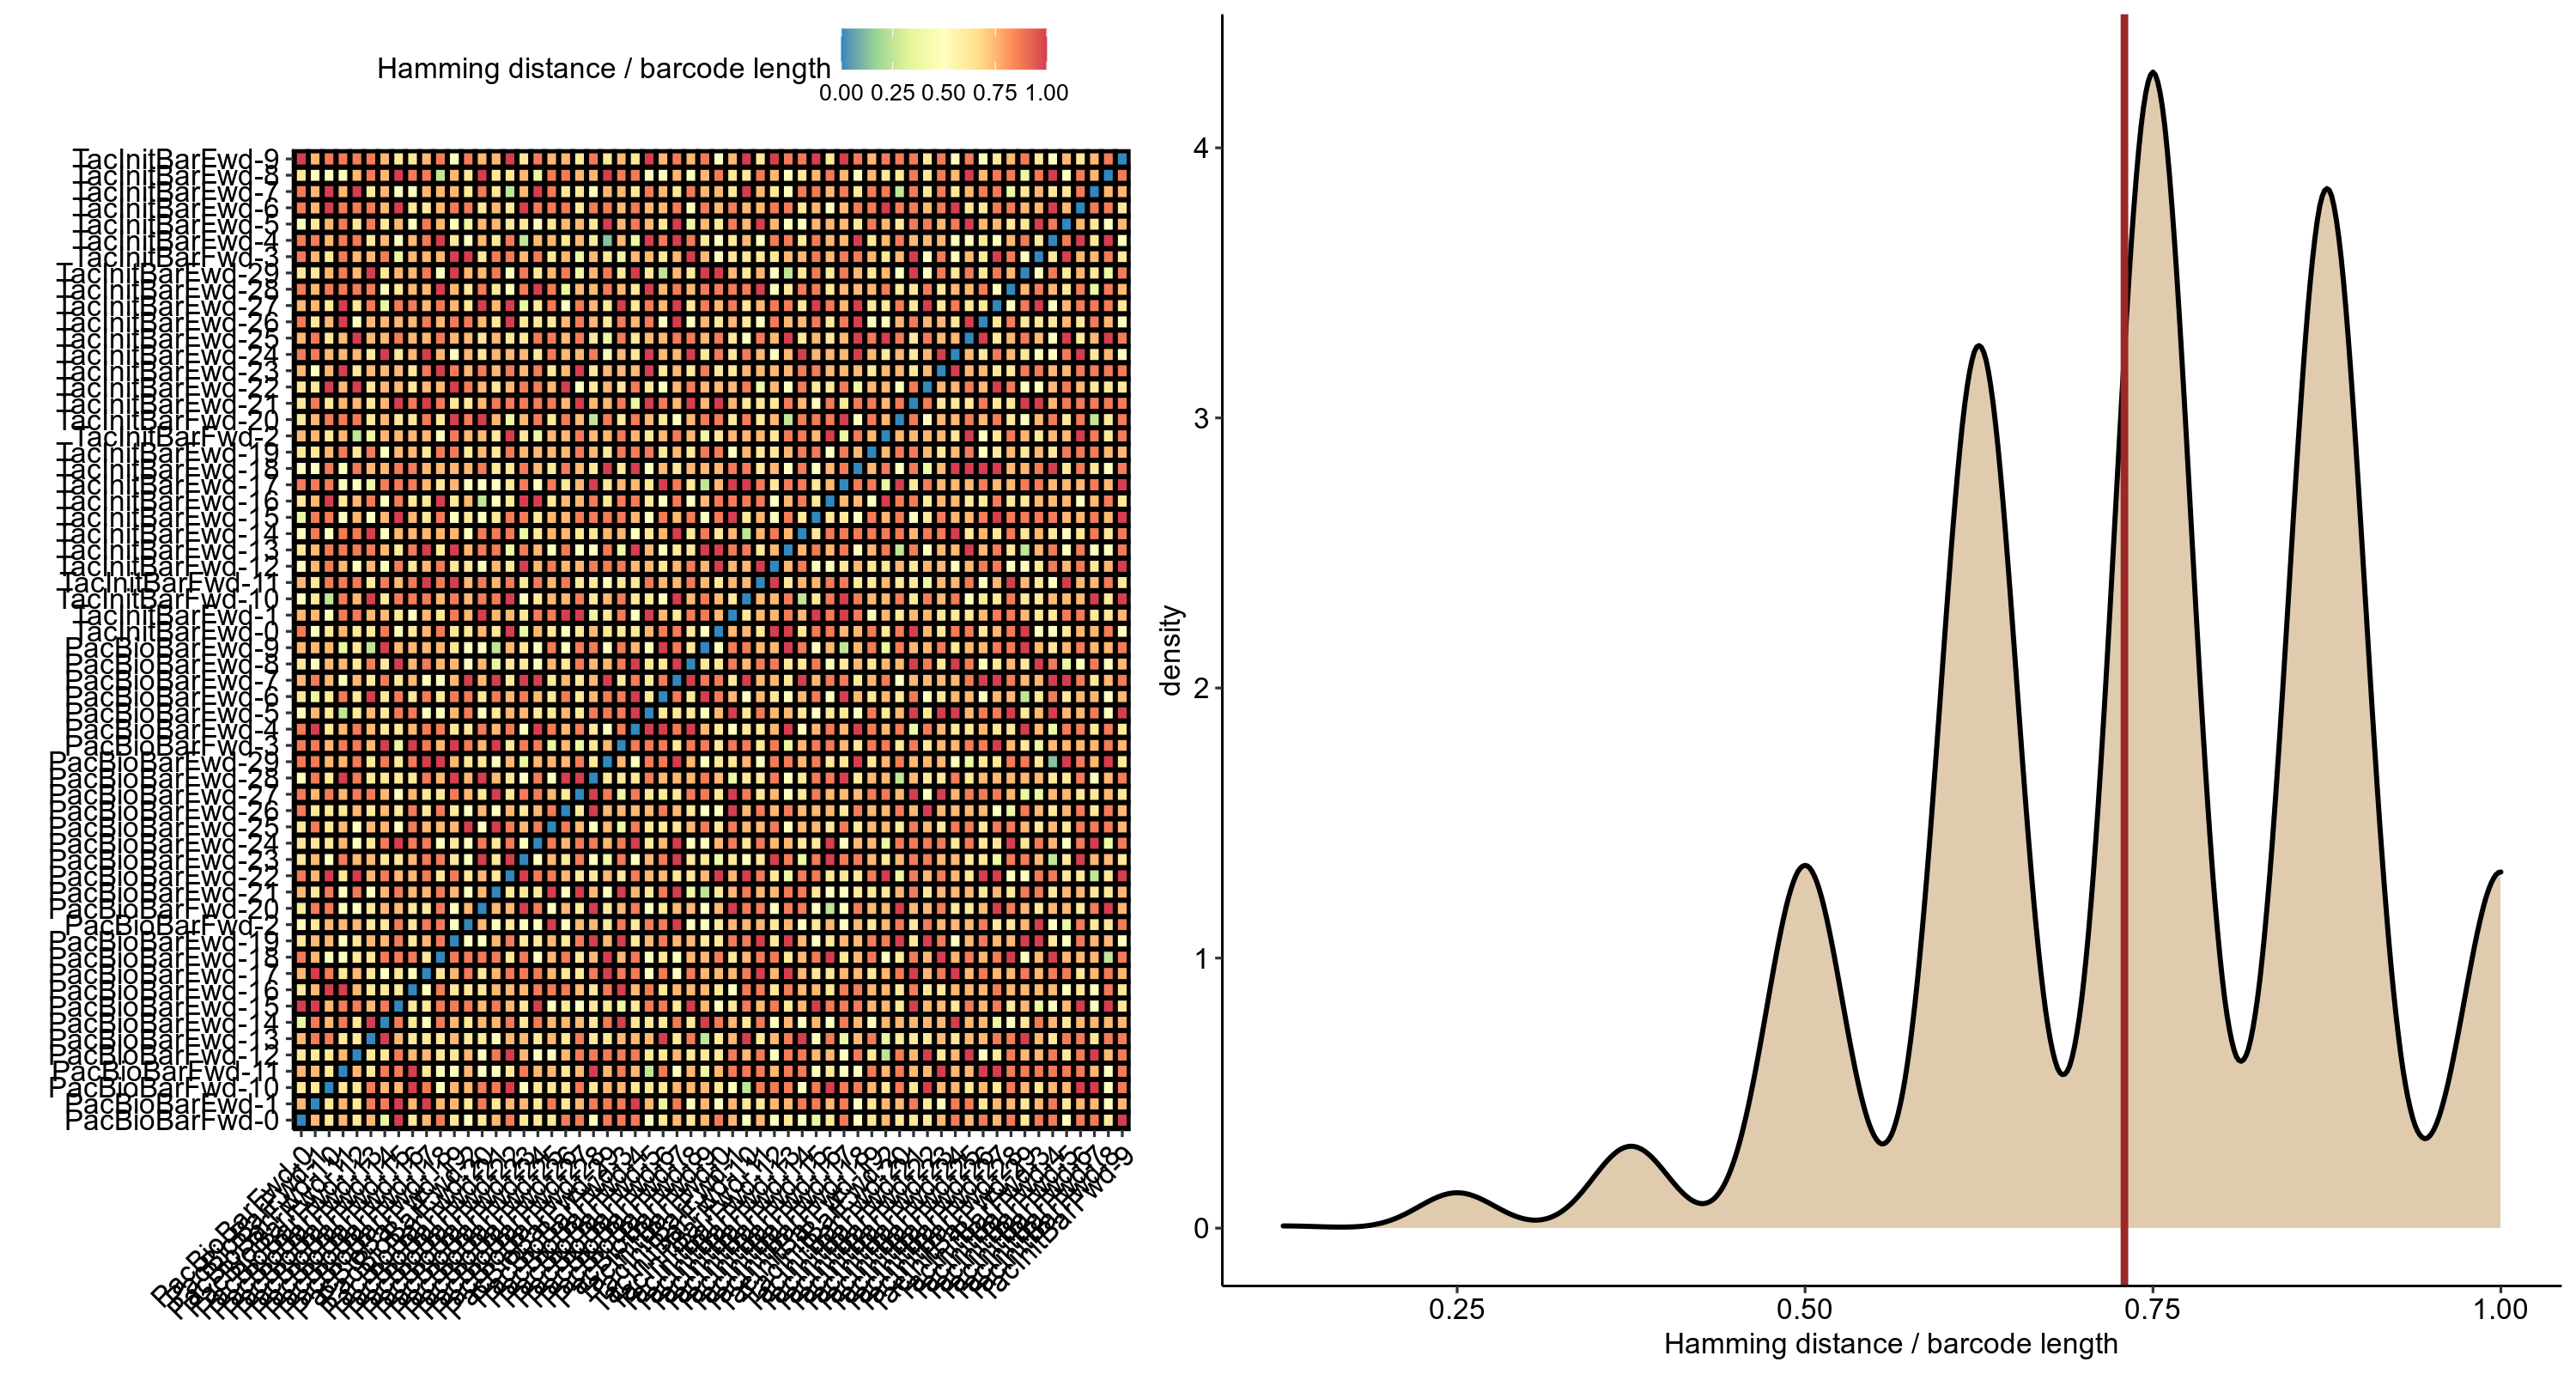

In [26]:
%%R -i ham_dist_table -w 15 -h 8 --units in -r 200

grid <- ggplot(
    ham_dist_table, 
    aes(x=p1_name, y=p2_name, fill=ham_dist)
    ) + geom_tile(color='black', size=1) + 
    scale_fill_distiller(palette='Spectral') + theme_pubr() + 
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    labs(x='', y='', fill='Hamming distance / barcode length')

box <- ggplot(
    subset(ham_dist_table, ham_dist > 0), 
    aes(x=ham_dist)
    ) + geom_density(color='black', size=1, fill='tan', alpha=0.7) + 
    scale_fill_brewer(palette='Spectral') + theme_pubr() +
    labs(x='Hamming distance / barcode length') +
    geom_vline(xintercept=mean(ham_dist_table$ham_dist), size=1.5, color='#9c2828')


ggarrange(grid, box, widths = c(1, 1.25))